# 추론 기반 기법과 신경망

## 신경망에서의 단어 처리

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[ 1.88158342 -0.73556246 -0.4603501 ]]


In [4]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
c.ndim

2

In [6]:
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
h

array([[-0.03366558, -1.40510033, -3.16857719]])

# 단순한 word2vec

## CBOW 모델의 추론 처리

In [8]:
import numpy as np
from common.layers import MatMul

c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

In [10]:
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

In [11]:
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

In [13]:
h0 = in_layer0.forward(c0)
h1 = in_layer0.forward(c1)
h = 0.5*(h0+h1)
s = out_layer.forward(h)
print(s)

[[-0.39361364 -0.91455659 -0.91162846 -1.25354864  0.6562381   0.98447192
  -1.76969067]]


# 학습 데이터 준비

## 맥락과 타깃

In [15]:
from common.util import preprocess

In [16]:
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [17]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [18]:
id_to_word

{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [19]:
word_to_id

{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [20]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [21]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [22]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [23]:
target

array([1, 2, 3, 4, 1, 5])

## 원핫 표현으로 변환

In [24]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [25]:
corpus.ndim

1

In [26]:
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [27]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [28]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [29]:
contexts = convert_one_hot(contexts, vocab_size)
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

# CBOW 모델 구현

In [32]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

In [37]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer, self.loss_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layers.params
            self.grads += layers.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1)*0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 학습 코드 구현

In [51]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer, self.loss_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1)*0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [52]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [53]:
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [54]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [55]:
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [57]:
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1001 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 1002 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 1003 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 1004 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 1005 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 1006 |  반복 1 / 2 | 시간 0[s] | 손실 0.35
| 에폭 1007 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 1008 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 1009 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 1010 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 1011 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 1012 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 1013 |  반복 1 / 2 | 시간 0[s] | 손실 0.35
| 에폭 1014 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 1015 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 1016 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 1017 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 1018 |  반복 1 / 2 | 시간 0[s] | 손실 0.35
| 에폭 1019 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 1020 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 1021 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 1022 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 1023 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 1024 |  반복 1 / 2 | 시간 0[s] | 

| 에폭 1824 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 1825 |  반복 1 / 2 | 시간 0[s] | 손실 0.25
| 에폭 1826 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 1827 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 1828 |  반복 1 / 2 | 시간 0[s] | 손실 0.16
| 에폭 1829 |  반복 1 / 2 | 시간 0[s] | 손실 0.25
| 에폭 1830 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 1831 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 1832 |  반복 1 / 2 | 시간 0[s] | 손실 0.25
| 에폭 1833 |  반복 1 / 2 | 시간 0[s] | 손실 0.25
| 에폭 1834 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 1835 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 1836 |  반복 1 / 2 | 시간 0[s] | 손실 0.14
| 에폭 1837 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 1838 |  반복 1 / 2 | 시간 0[s] | 손실 0.14
| 에폭 1839 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 1840 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 1841 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 1842 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 1843 |  반복 1 / 2 | 시간 0[s] | 손실 0.15
| 에폭 1844 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 1845 |  반복 1 / 2 | 시간 0[s] | 손실 0.15
| 에폭 1846 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 1847 |  반복 1 / 2 | 시간 0[s] | 

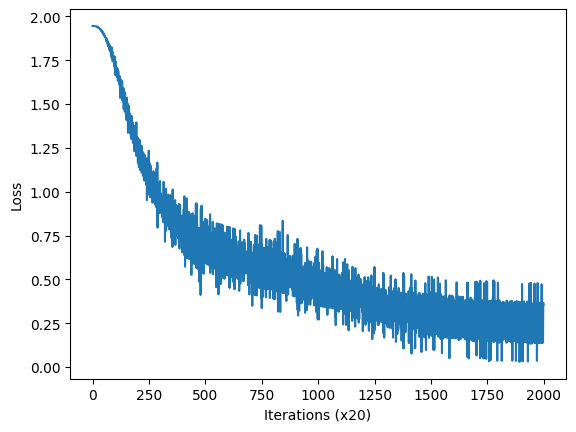

In [58]:
trainer.plot()

In [61]:
word_vecs[0]

array([ 2.6707451, -1.6442621, -0.5847665,  1.1619233, -0.8026543],
      dtype=float32)

In [64]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 2.6707451 -1.6442621 -0.5847665  1.1619233 -0.8026543]
say [-0.00921034  0.7644166   1.6862581  -0.43474042  1.669456  ]
goobye [-0.54798555 -0.642559   -1.7834144   1.3510633  -1.741903  ]
and [-1.9342688  1.8969214  1.4211481 -1.7507019  1.4195617]
i [-0.535306  -0.6277422 -1.7643728  1.3459346 -1.7174817]
hello [ 2.6600611 -1.6649162 -0.606956   1.16007   -0.8170736]
. [ 1.463556  -1.6983135  1.450472   1.6578728  1.457977 ]
